# Exploring Discrete Compactness

In this notebook, we explore some discrete methods of computing district compactness, and compare their outputs.

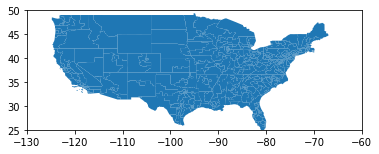

In [110]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyproj as pyproj

df_big = gpd.read_file('./cd2013/tl_rd13_us_cd113.shp')
df_small = gpd.read_file('./counties2013/cb_2013_us_county_500k.shp')
df_small = df_small.to_crs({"init": "esri:102009"})
bad_geoids = ['02','15','69','72','60','78','66']
contig_us = df_big.iloc[[geoid[:2] not in bad_geoids for geoid in df_big['GEOID']]].copy()
contig_us.plot()
ax=plt.axis([-130,-60,25,50])
plt.show()

We start off by computing the area, perimeter, and Polsby-Popper score of every district in the LATLONG projection:

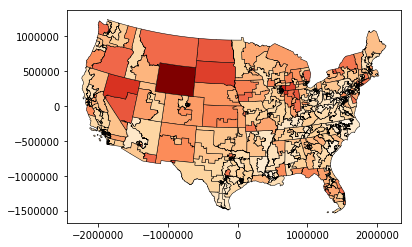

In [111]:
contig_us = contig_us.to_crs({"init": "esri:102009"})
contig_us['area'] = contig_us.geometry.area
contig_us['perim'] = contig_us.geometry.boundary.length
contig_us['polsby'] = 4*np.pi*contig_us['area']/contig_us['perim']**2
contig_us.plot(column='polsby',cmap='OrRd', edgecolor='black', linewidth=0.5)
plt.show()

The first discrete compactness score will replace perimeter with the number of small units touching the shape boundary, and replace area with the number of small units touching the shape itself.

In [112]:
cols = ['GEOID','dperim','darea']

discrete_data = pd.DataFrame(columns=cols)

for i, big_unit in contig_us.iterrows():
    discrete_perimeter = 0
    discrete_area = 0
    for i, small_unit in df_small.iterrows():
        if small_unit.geometry.intersects(big_unit.geometry):
            discrete_area += 1
        if small_unit.geometry.intersects(big_unit.geometry.boundary):
            discrete_perimeter +=1
    perimeter = big_unit.geometry.boundary.length
    area = big_unit.geometry.area
    discrete_data = discrete_data.append(pd.DataFrame([[big_unit['GEOID'],discrete_perimeter,discrete_area]], columns=cols))
contig_us = contig_us.merge(discrete_data, on='GEOID')

We can now play around with these discrete measures. Let's use the simple ratio of discrete perimeter to discrete area.

In [109]:
tmp = contig_us.iloc[[contig_us.iloc[j]['dperim'] == 0 for j,row in contig_us.iterrows()]]
tmp

,STATEFP,CD113FP,GEOID,NAMELSAD,LSAD,CDSESSN,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,area,perim,polsby,dperim,darea
0,37,01,3701,Congressional District 1,C2,113,G5200,N,14227693111,414257512,+36.1119104,-077.5009008,"POLYGON ((1439533.54300335 -276450.2078478296,...",1.301363e+10,2.002919e+06,0.040764,0,0
1,37,03,3703,Congressional District 3,C2,113,G5200,N,20229273757,10851171398,+35.4057865,-076.6296737,POLYGON ((1527654.334155532 -414996.5165245291...,2.768513e+10,1.825750e+06,0.104370,0,0
2,25,04,2504,Congressional District 4,C2,113,G5200,N,1730858364,86473790,+41.9971989,-071.2275271,"POLYGON ((1867938.526483841 494583.9659722674,...",1.603788e+09,3.477246e+05,0.166681,0,0
3,25,09,2509,Congressional District 9,C2,113,G5200,N,3146229191,5152011870,+41.6948531,-070.4851689,"POLYGON ((1913517.636367586 449374.3389569067,...",7.322223e+09,5.628765e+05,0.290420,0,0
4,25,08,2508,Congressional District 8,C2,113,G5200,N,845313811,447648415,+42.1947343,-070.9440053,"POLYGON ((1892187.877709982 493942.9990219194,...",1.141172e+09,3.265538e+05,0.134478,0,0
5,51,11,5111,Congressional District 11,C2,113,G5200,N,479388902,21677941,+38.7912640,-077.2942679,"POLYGON ((1501213.242168304 38279.8761334167, ...",4.427679e+08,2.440596e+05,0.093410,0,0
6,08,04,0804,Congressional District 4,C2,113,G5200,N,98685953201,435877019,+39.0706831,-103.4138530,POLYGON ((-756689.5079411884 -50278.4104231656...,8.759733e+10,1.725041e+06,0.369915,0,0
7,21,06,2106,Congressional District 6,C2,113,G5200,N,11125095359,119881178,+38.0534473,-084.1547782,POLYGON ((892504.9215877239 -153763.2077638049...,9.948396e+09,8.625844e+05,0.168020,0,0
8,01,06,0106,Congressional District 6,C2,113,G5200,N,10802402204,177149895,+33.2602118,-086.7134267,POLYGON ((758937.7978122301 -694607.5706410202...,9.862097e+09,9.487920e+05,0.137669,0,0
9,48,04,4804,Congressional District 4,C2,113,G5200,N,26218531554,1029312841,+33.2982880,-095.4180633,POLYGON ((-82783.10637424303 -642265.020841630...,2.446904e+10,1.324700e+06,0.175223,0,0


In [105]:
contig_us['dpolsby'] = contig_us['darea']/contig_us['dperim']
contig_us.plot(column='dpolsby',cmap='OrRd',edgecolor='black', linewidth=0.5)
tmp = contig_us.iloc[[contig_us.iloc[i]['dperim'] == 0 for i,d in contig_us.iterrows()]].copy()

ZeroDivisionError: division by zero

Let's check which districts get better or worse! We do this by ranking the districts by Polsby-Popper scores, and then ranking them by discrete Polsby-Popper scores, and seeing which district jumped the most ranks.

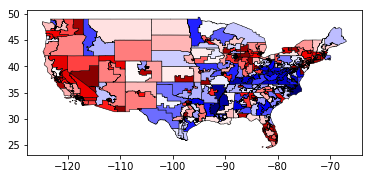

In [76]:
contig_us['dpolsby_rank'] = contig_us['dpolsby'].rank(ascending=False)
contig_us['polsby_rank'] = contig_us['polsby'].rank(ascending=False)
contig_us['rank_diff'] = contig_us['dpolsby_rank'] - contig_us['polsby_rank']
contig_us.plot(column='rank_diff',cmap='seismic',edgecolor='black', linewidth=0.5)